# Classification de texte - Affinage d'un modèle GPT-2/DistilGPT-2

## GPT-2 (Generative Pre-trained Transformer 2)
GPT-2 est un modèle de langage auto-régressif qui utilise l'architecture Transformer. Contrairement à BERT qui est bidirectionnel, GPT-2 est un modèle unidirectionnel qui prédit séquentiellement le mot suivant en se basant uniquement sur les mots précédents (contexte gauche).
Le modèle a été développé par OpenAI et représente une évolution significative par rapport à son prédécesseur GPT-1. GPT-2 a été entraîné sur un corpus massif de textes du web appelé WebText, contenant environ 8 millions de documents pour un total de 40 Go de texte.
GPT-2 utilise l'apprentissage auto-supervisé, ce qui signifie qu'il n'a pas besoin de données étiquetées manuellement. Sa tâche de pré-entraînement est simplement de prédire le mot suivant dans une séquence, ce qui lui permet d'apprendre les structures et les patterns du langage naturel.
Caractéristiques principales de GPT-2 :

Architecture Transformer décodeur uniquement (decoder-only)
Apprentissage auto-régressif (prédiction du token suivant)
Attention masquée pour garantir que le modèle ne voit que les tokens précédents
Différentes tailles de modèles allant de 117M à 1.5B paramètres
Capacité de génération de texte cohérent sur de longues séquences

GPT-2 utilise principalement deux types d'embeddings :

Token embeddings (représentations des mots)
Position embeddings (pour encoder l'ordre des mots)

Le modèle est particulièrement efficace pour des tâches génératives comme :

Génération de texte
Complétion de phrases
Réponse à des questions
Résumé de texte
Traduction (dans une certaine mesure)

Contrairement à BERT qui masque aléatoirement des tokens dans la séquence, GPT-2 apprend à prédire séquentiellement le token suivant, ce qui en fait un modèle particulièrement adapté à la génération de texte. Cette approche auto-régressive permet à GPT-2 de produire des textes qui maintiennent la cohérence contextuelle sur de longues séquences.

## Installation des librairies nécessaires

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
import preprocessing as pp

## Lecture des données

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('./datasets/X_y_train.csv')

In [8]:
df.head()

,Id,text,level
0,0,\r\r\n Hi! Just some words about the prod...,3
1,1,"\r\r\n Dear Sir and Madam,I am writing to...",3
2,2,\r\r\n Isabella tells John her life and h...,1
3,3,\r\r\n From: fabsymon To: Everybody Subje...,1
4,4,\r\r\n my name is alison . i live in fren...,0


In [9]:
df_cleaned = df["text"].apply(lambda x : pp.remove_noise(x))
y=df["level"]
df_cleaned

,text
0,Hi! Just some words about the product With the...
1,Dear Sir and am writing to enquire about the p...
2,Isabella tells John her life and her problems ...
3,From: fabsymon To: Everybody Subject: Tennis r...
4,my name is alison i live in french DAY IS VERY...
...,...
13366,This week end there will a big concert in bord...
13367,"Hi, Thank you for sending me the results of th..."
13368,"Hello Aunt Jane, happy to help you. You have t..."
13369,"I first time a saw my partner, I was with frie..."


In [10]:
from collections import Counter

Counter(y)

Counter({3: 1757, 1: 3723, 0: 3808, 2: 3700, 4: 383})

## Class Dataset

In [11]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
labels = {
    "0": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4
         }

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [label for label in df['level']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

## Séparation des données pour le test, la validation et l'entraînement

In [12]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

10696 1337 1338


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Construction du modèle de classification de texte

In [8]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)


    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

## Entraînement

In [15]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    class_weights = torch.FloatTensor([ 1/Counter(y)[i] for i in range(0,5)])
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        best_eval_accuracy=0
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            model.zero_grad()

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
            avg_val_accuracy=total_acc_val / len(val_data)
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {avg_val_accuracy: .3f}")



In [16]:
for model_name in [
    "gpt2",
    "distilgpt2"
    ]:
  for epochs in [2]:
    for lr in [1e-5]:
      train(SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name=model_name),df_train,df_val,lr,epochs)

100%|██████████| 5348/5348 [07:46<00:00, 11.45it/s]


Epochs: 1 | Train Loss:  0.276             | Train Accuracy:  0.810             | Val Loss:  0.144             | Val Accuracy:  0.910


100%|██████████| 5348/5348 [07:45<00:00, 11.48it/s]


Epochs: 2 | Train Loss:  0.073             | Train Accuracy:  0.953             | Val Loss:  0.143             | Val Accuracy:  0.924


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

100%|██████████| 5348/5348 [04:31<00:00, 19.73it/s]


Epochs: 1 | Train Loss:  0.263             | Train Accuracy:  0.823             | Val Loss:  0.135             | Val Accuracy:  0.912


100%|██████████| 5348/5348 [04:30<00:00, 19.74it/s]


Epochs: 2 | Train Loss:  0.077             | Train Accuracy:  0.951             | Val Loss:  0.120             | Val Accuracy:  0.929


In [19]:
EPOCHS = 2
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
LR = 2e-5

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 5348/5348 [07:51<00:00, 11.34it/s]


Epochs: 1 | Train Loss:  0.255             | Train Accuracy:  0.830             | Val Loss:  0.154             | Val Accuracy:  0.909


100%|██████████| 5348/5348 [07:45<00:00, 11.48it/s]


Epochs: 2 | Train Loss:  0.055             | Train Accuracy:  0.962             | Val Loss:  0.173             | Val Accuracy:  0.904


## Evaluation

In [20]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()


    # Tracking variables
    predictions_labels = []
    true_labels = []

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels

true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:  0.899


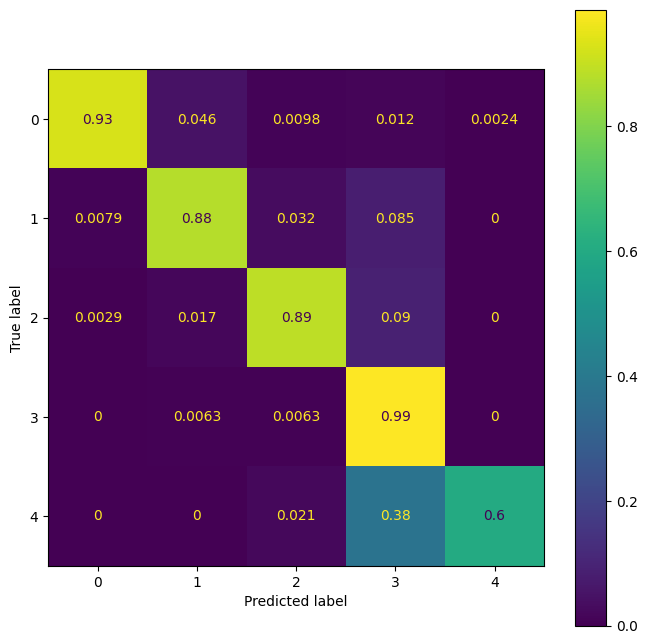

In [21]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)

## Sauvegarde du modèle

In [22]:
# save trained model
torch.save(model, "./gpt2.pt")

## Inférence

In [9]:
model = torch.load("./gpt2.pt")

<ipython-input-9-46d633f42843>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("./gpt2.pt")


In [10]:
df_test = pd.read_csv('./datasets/X_test.csv')
df_test['text'] = df_test['text'].apply(lambda x : pp.remove_noise(x))

In [11]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [66]:
class Dataset_test(torch.utils.data.Dataset):
    def __init__(self, df):
        self.texts = [ ]
        for text in df['text']:
          tokenized_text = tokenizer(text,padding='max_length',max_length=128,truncation=True,add_special_tokens=True,return_tensors="pt")
          if tokenized_text["input_ids"].shape!=(1,0):
            self.texts.append(tokenized_text)
    def __len__(self):
        return len(self.texts)

    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        return batch_texts

## Soumission

In [67]:
l_res_submission=[]
device=torch.device("cuda")
test = Dataset_test(df_test)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
with torch.no_grad():
  for test_input in tqdm(test_dataloader):
      test_input = test_input.to(device)
      mask = test_input['attention_mask'].to(device)
      input_id = test_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask).cpu()
      l_res_submission+=output.argmax(dim=1).cpu().numpy().flatten().tolist()

100%|██████████| 2228/2228 [00:42<00:00, 52.61it/s]


In [ ]:
submission = pd.DataFrame(l_res_submission,columns=["level"])
submission.to_csv("./submission_gpt.csv")